In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
sto_word = list(set(stopwords.words('english')))
from nltk.stem import WordNetLemmatizer  

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

pd.set_option('mode.chained_assignment', None)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import plotly.express as px

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pickle
#pickle.dump((combined_data_fe), open('/content/gdrive/MyDrive/cs1/combined_data_fe.pkl','wb'))
combined_data_fe = pickle.load(open('/content/gdrive/MyDrive/cs1/combined_data_fe4.pkl', 'rb'))
fastext_dict     = pickle.load(open('/content/gdrive/MyDrive/cs1/data/ft/fastext_dict.pkl', 'rb'))

In [ ]:
combined_data_fe.head()

,description,commenting,ogling,grouping,noun_count,punctuation_count,stopword_count,p_or_a,idf_freqently,idf_rare,1_2_3_4gm,description_len,word_count,word_density
0,walking along crowded street holding mum hand ...,0,0,1,8,6,15,1,1,0,19,101,17,5.611111
1,incident took place evening metro two guy star...,0,1,0,5,2,7,1,1,0,22,57,9,5.700000
2,waiting bus man came bike offering liftvto you...,1,0,0,5,2,9,1,1,0,13,54,9,5.400000
3,incident happened inside train,0,0,0,2,0,1,1,1,0,5,30,4,6.000000
4,witnessed incident chain brutally snatched eld...,0,0,0,7,2,9,1,1,0,19,83,11,6.916667


In [ ]:
y = combined_data_fe[['commenting', 'ogling', 'grouping']]
combined_data_fe.drop(['commenting', 'ogling', 'grouping'], axis=1, inplace=True)
x = combined_data_fe

In [ ]:
x.shape, y.shape

((9193, 11), (9193, 3))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20, random_state=42)

In [ ]:
print(f'x train shape {x_train.shape}')
print(f'y train shape {y_train.shape}')
print(f'x test shape  {x_test.shape}')
print(f'y test shape  {y_test.shape}')

x train shape (7354, 11)
y train shape (7354, 3)
x test shape  (1839, 11)
y test shape  (1839, 3)


In [ ]:
def normalize(frame_tr, frame_te, column):                   #---------------------- in 2

  norm = Normalizer()
  tr   = norm.fit_transform(frame_tr[column].values.reshape(-1,1))
  te   = norm.transform(frame_te[column].values.reshape(-1,1))
  return tr, te

In [ ]:
def vectorizer(train, test, column, type, analyz, ndim):    #----------- in 1

  '''takes train : train data frame,
           test  : test data frame,
          column : text data column
          analyz : word level or character level tfidf'''
  
  if type == 'bow' and analyz == 'word':
    bow_vect   = CountVectorizer(ngram_range=(1,1), analyzer=analyz, stop_words='english')
    train      = bow_vect.fit_transform(train[column])
    test       = bow_vect.transform(test[column])

  if type == 'tfidf' and analyz == 'word':
    tfidf_vect = TfidfVectorizer(ngram_range=(1,1), analyzer=analyz, stop_words='english')
    train      = tfidf_vect.fit_transform(train[column])
    test       = tfidf_vect.transform(test[column])
    #pickle.dump((tfidf_vect), open('/content/tfidf_vect.pkl','wb'))

  if type == 'tfidf' and analyz == 'char':
    tfidf_vect = TfidfVectorizer(ngram_range=(1,4), analyzer=analyz, stop_words='english')
    train      = tfidf_vect.fit_transform(train[column])
    test       = tfidf_vect.transform(test[column])
    #pickle.dump((tfidf_vect), open('/content/tfidf_vect.pkl','wb'))

  if type == 'fastext':
    train = fastext_embedding(train[column].values, fastext_dict, ndim)
    test  = fastext_embedding(test[column].values, fastext_dict, ndim)

  return train, test

In [ ]:
from scipy.sparse import hstack                                  ## --------------------------- in 3
from sklearn.preprocessing import Normalizer, MinMaxScaler
import pickle
def data_for_model(frame_tr, frame_te,  type, analyz, ndim):

  '''frame_tr, frame_te : x_train, x_test frame,
     type               : tfidf/fastext/dl/bert,
     analyz             : if char level needs to taken or not,
     nidm               : maximum dimenssion'''
     

  col =  frame_tr.columns
  vect_x_train, vect_x_test = vectorizer(frame_tr, frame_te, col[0], type, analyz, ndim)

  x_train_p_or_a = frame_tr[col[4]].values.reshape(-1,1)
  x_test_p_or_a  = frame_te[col[4]].values.reshape(-1,1)

  x_train_idf_frequently = frame_tr[col[5]].values.reshape(-1,1)
  x_test_idf_frequently  = frame_te[col[5]].values.reshape(-1,1)

  x_train_idf_rare = frame_tr[col[6]].values.reshape(-1,1)
  x_test_idf_rare  = frame_te[col[6]].values.reshape(-1,1)

  x_train_noun_count, x_test_noun_count                = normalize(frame_tr, frame_te, col[1])
  x_train_punctuation_count, x_test_punctuation_count  = normalize(frame_tr, frame_te, col[2])
  x_train_stopword_count, x_test_stopword_count        = normalize(frame_tr, frame_te, col[3])
  x_train_gm, x_test_gm                                = normalize(frame_tr, frame_te, col[7])
  x_train_desc_len, x_test_desc_len                    = normalize(frame_tr, frame_te, col[8])
  x_train_word_count, x_test_word_count                = normalize(frame_tr, frame_te, col[9])
  x_train_word_density, x_test_word_density            = normalize(frame_tr, frame_te, col[10])
  
  if type == 'bow': 
    x_train_final = hstack((vect_x_train, x_train_noun_count, x_train_punctuation_count, x_train_stopword_count, x_train_p_or_a, 
                          x_train_idf_frequently, x_train_idf_rare, x_train_desc_len, x_train_word_count, 
                          x_train_word_density)).tocsr()

    x_test_final  = hstack((vect_x_test, x_test_noun_count, x_test_punctuation_count, x_test_stopword_count, 
                          x_test_p_or_a, x_test_idf_frequently, x_test_idf_rare, x_test_desc_len, x_test_word_count, 
                          x_test_word_density)).tocsr()
  
  
  if type == 'tfidf': 
    x_train_final = hstack((vect_x_train, x_train_noun_count, x_train_punctuation_count, x_train_stopword_count, x_train_p_or_a, 
                          x_train_idf_frequently, x_train_idf_rare, x_train_desc_len, x_train_word_count, 
                          x_train_word_density)).tocsr()

    x_test_final  = hstack((vect_x_test, x_test_noun_count, x_test_punctuation_count, x_test_stopword_count, 
                          x_test_p_or_a, x_test_idf_frequently, x_test_idf_rare, x_test_desc_len, x_test_word_count, 
                          x_test_word_density)).tocsr()

  if type == 'fastext':

    x_train_final = np.concatenate([vect_x_train, x_train_noun_count, x_train_punctuation_count, x_train_stopword_count, x_train_p_or_a, 
                          x_train_idf_frequently, x_train_idf_rare, x_train_desc_len, x_train_word_count, 
                          x_train_word_density], axis=1)

    x_test_final  = np.concatenate([vect_x_test, x_test_noun_count, x_test_punctuation_count, x_test_stopword_count, 
                          x_test_p_or_a, x_test_idf_frequently, x_test_idf_rare, x_test_desc_len, x_test_word_count, 
                          x_test_word_density], axis=1)
    

  if type == 'dl':
      
    path = '/content/gdrive/MyDrive/cs1/dl_features.pkl'

    if os.path.isfile(path):
      x_trn_dl, x_tes_dl = pickle.load(open('/content/gdrive/MyDrive/cs1/dl_features.pkl','rb'))

    else:
      x_train_final = np.concatenate([x_trn_dl, x_train_noun_count, x_train_punctuation_count, x_train_stopword_count, x_train_p_or_a, 
                          x_train_idf_frequently, x_train_idf_rare, x_train_desc_len, x_train_word_count, 
                          x_train_word_density], axis=1)

      x_test_final  = np.concatenate([x_tes_dl, x_test_noun_count, x_test_punctuation_count, x_test_stopword_count, 
                          x_test_p_or_a, x_test_idf_frequently, x_test_idf_rare, x_test_desc_len, x_test_word_count, 
                          x_test_word_density], axis=1)
    
  if type == 'bert':
    
    path = '/content/gdrive/MyDrive/cs1/bert_features2.pkl'

    if os.path.isfile(path):
      x_train_final, x_test_final = pickle.load(open('/content/gdrive/MyDrive/cs1/bert_features2.pkl','rb'))
    
    else:
      x_train_final = final_bert_embedd(frame_tr, col[0])
      x_test_final  = final_bert_embedd(frame_te, col[0])

  return x_train_final, x_test_final

In [ ]:
from gensim.models import FastText

def load_fast_text():
  fastext = {}
  f = open('/content/gdrive/MyDrive/cs1/data/ft/wiki-news-300d-1M.vec', encoding='utf-8')
  for line in f:
    value = line.strip().split(' ')
    word  = value[0].lower()
    coef  = np.array(value[1:], dtype='float32')
    fastext[word] = coef
  f.close()
  print(f'Found {len(fastext)} word vector')
  return fastext

fastext_dict = load_fast_text()

In [ ]:
def fastext_embedding(x, dic, ndim):
  embedd = []
  for sent in x:
    vector = np.zeros(ndim)               # as word vectors are of zero length
    for word in sent.split():
      if word in dic.keys():
        vector += fastext_dict[word]
    embedd.append(vector)
  
  return np.array(embedd)


In [ ]:
pip install transformers

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 33.3 MB/s 
     |████████████████████████████████| 895 kB 61.0 MB/s 
     |████████████████████████████████| 636 kB 47.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizer, TFDistilBertModel, pipeline

In [ ]:
from tqdm import tqdm
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Loading Tokenizer
config    = DistilBertConfig.from_pretrained('distilbert-base-uncased', output_hidden_states = True) # Loading COnfig File
model     = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config) # Loading Model

pipe_nlp = pipeline('feature-extraction', model=model, config=config, tokenizer=tokenizer, framework='tf')

def final_bert_layers_tokens(string):

  '''extract layers'''

  input  = tokenizer(string, return_tensors = "tf")
  output = model(input) 
  output = np.concatenate((output[1][5][0,0,:], output[1][6][0,0,:]), axis=0)  #output[1][3][0,0,:],output[1][4][0,0,:],
  return output


In [ ]:
def final_bert_embedd(frame, column):

  ''' EXTRACT EMBEDDING''''
  
  sent_embd = []
  for i in tqdm(frame[column].values):
    sent = i[:512]
    sent_embd.append(final_bert_layers_tokens(sent))

  return np.array(sent_embd)


In [ ]:
import pickle
pickle.dump((x_train_bert, x_test_bert), open('/content/gdrive/MyDrive/cs1/bert_features2.pkl','wb'))

In [ ]:
x_train_bow_w, x_test_bow_w = data_for_model(x_train, x_test, 'bow', 'word',_)
x_train_bow_w.shape, x_test_bow_w.shape

((7354, 7914), (1839, 7914))

In [ ]:
x_train_tfidf_w, x_test_tfidf_w = data_for_model(x_train, x_test, 'word')

In [ ]:
x_train_tfidf_w.shape, x_test_tfidf_w.shape

((7354, 7914), (1839, 7914))

In [ ]:
x_train_tfidf_c, x_test_tfidf_c= data_for_model(x_train, x_test, 'tfidf', 'char', _)

In [ ]:
x_train_tfidf_c.shape, x_test_tfidf_c.shape

((7354, 30150), (1839, 30150))

In [ ]:
x_train_ft, x_test_ft = data_for_model(x_train, x_test, 'fastext', _, 300)

In [ ]:
x_train_ft.shape, x_test_ft.shape

((7354, 309), (1839, 309))

In [ ]:
x_train_dl, x_test_dl = data_for_model(x_train, x_test, 'dl', _, _)

In [ ]:
x_train_dl.shape, x_test_dl.shape

((7354, 109), (1839, 109))

In [ ]:
x_train_bert, x_test_bert = data_for_model(x_train, x_test,'bert', _, _)
x_train_bert.shape, x_test_bert.shape

((7354, 1536), (1839, 1536))

#set1 bow word

**MULTINOMIAL NB**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [MultinomialNB()],
        "classifier__alpha": [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]}]

mb_pred, best_clf = model(x_train_bow_w, y_train, x_test_bow_w, tqdm(params), 'multi.nb')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_mult_nb_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 228.08it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   38.3s finished


best cv params for multi.nb model : {'classifier__alpha': 0.3, 'classifier': MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)}
best cv score for multi.nb model  : 0.6355642588662562
CPU times: user 46.9 s, sys: 8.94 s, total: 55.9 s
Wall time: 39.5 s


In [ ]:
metrics(y_test, mb_pred)

Hamming Loss      :  0.1868769258655066
Exact Match Ratio :  0.5725938009787929
Recall            :  0.5976871576384662
Precision         :  0.7263313609467456
Fl score          :  0.6557595993322204


**LOGISTIC REGRESSION**

In [ ]:
#0:[{0:1.61 ,1:1.0}], 1:[{0:3.82 ,1:1.0}], 2:[{0:2.3, 1:1.0}]
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(class_weight={0:2.3 ,1:1.0} ,random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]      #["newton-cg", "liblinear", "sag"]}]

lr_pred, best_clf = model(x_train_bow_w, y_train, x_test_bow_w, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_log_reg_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 344.56it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   46.7s finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 1.5, 'classifier': LogisticRegression(C=1.5, class_weight={0: 2.3, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.6569579368455659


In [ ]:
metrics(y_test, lr_pred)

Hamming Loss      :  0.16838861700199384
Exact Match Ratio :  0.6144643828167482
Recall            :  0.5976871576384662
Precision         :  0.7856
Fl score          :  0.6788800553059108


In [ ]:
##LABEL POWESET HAVE NO CV_RESULT_ PARAM SO CANNOT PLOT FOR CV SCORES.

**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [LinearSVC(max_iter=5000, random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]
        #'classifier__kernel': ['linear']}]

cvm_lin_pred, best_clf = model(x_train_bow_w, y_train, x_test_bow_w, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 304.53it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


best cv params for svc lin model : {'classifier__class_weight': {0: 1.61, 1: 1.0}, 'classifier__C': 0.5, 'classifier': LinearSVC(C=0.5, class_weight={0: 1.61, 1: 1.0}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)}
best cv score for svc lin model  : 0.6377196521383581
CPU times: user 1min 34s, sys: 7.3 s, total: 1min 42s
Wall time: 1min 31s


In [ ]:
metrics(y_test, cvm_lin_pred)

Hamming Loss      :  0.1845205727750589
Exact Match Ratio :  0.5807504078303426
Recall            :  0.6092513694461351
Precision         :  0.7269426289034132
Fl score          :  0.6629139072847682


**DT**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10]}]

dt_pred, best_clf = model(x_train_bow_w, y_train, x_test_bow_w, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 236.95it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.4min finished


best cv params for decision tree model : {'classifier__min_samples_split': 4, 'classifier__max_depth': 18, 'classifier__criterion': 'gini', 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=18, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}
best cv score for decision tree model  : 0.5940296519256923
CPU times: user 2min 50s, sys: 1.04 s, total: 2min 51s
Wall time: 2min 50s


In [ ]:
metrics( y_test, dt_pred)

Hamming Loss      :  0.18705818379554107
Exact Match Ratio :  0.5747688961392061
Recall            :  0.4564820450395618
Precision         :  0.843644544431946
Fl score          :  0.5924170616113745


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 80, 250, 500],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred, best_clf = model(x_train_bow_w, y_train, x_test_bow_w, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 409.32it/s]

Fitting 3 folds for each of 10 candidates, totalling 30 fits



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.5min finished


best cv params for random forest model : {'classifier__n_estimators': 80, 'classifier__max_samples': 0.75, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 250, 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3.82, 1: 1.0}, criterion='gini',
                       max_depth=250, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=0.75, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.6464883929932966
CPU times: user 4min 27s, sys: 1.55 s, total: 4min 29s
Wall time: 4min 28s


In [ ]:
metrics(y_test, rf_pred)

Hamming Loss      :  0.16983868044226935
Exact Match Ratio :  0.6171832517672649
Recall            :  0.5696895922093731
Precision         :  0.8027444253859348
Fl score          :  0.6664293342826628


In [ ]:
from prettytable import PrettyTable
k = PrettyTable()
k.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k.add_row(["bow word + Numerical",'MULTINOMIAL NB',0.1869, 0.5726, 0.5977, 0.7263, 0.6557])
k.add_row(["bow word + Numerical",'LOGISTIC REGRESSION',0.1684, 0.6145, 0.5977, 0.7856, 0.6789])
k.add_row(["bow word + Numerical",'LINEAR SVM',0.1845, 0.5808, 0.6093, 0.7269, 0.6629])
k.add_row(["bow word + Numerical",'DESICION TREE',0.1871, 0.5748, 0.4565, 0.8436, 0.5924])
k.add_row(["bow word + Numerical",'RANDOM FOREST',0.1698, 0.6172, 0.5697, 0.8027, 0.6664])
print(k)

+----------------------+---------------------+--------------+--------+--------+-----------+----------+
|      Vectorizer      |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+----------------------+---------------------+--------------+--------+--------+-----------+----------+
| bow word + Numerical |    MULTINOMIAL NB   |    0.1869    | 0.5726 | 0.5977 |   0.7263  |  0.6557  |
| bow word + Numerical | LOGISTIC REGRESSION |    0.1684    | 0.6145 | 0.5977 |   0.7856  |  0.6789  |
| bow word + Numerical |      LINEAR SVM     |    0.1845    | 0.5808 | 0.6093 |   0.7269  |  0.6629  |
| bow word + Numerical |    DESICION TREE    |    0.1871    | 0.5748 | 0.4565 |   0.8436  |  0.5924  |
| bow word + Numerical |    RANDOM FOREST    |    0.1698    | 0.6172 | 0.5697 |   0.8027  |  0.6664  |
+----------------------+---------------------+--------------+--------+--------+-----------+----------+


##set1 tfidf word

**MULTINOMIAL NB**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [MultinomialNB()],
        "classifier__alpha": [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]}]

mb_pred, best_clf = model(x_train_tfidf_w, y_train, x_test_tfidf_w, tqdm(params), 'multi.nb')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_mult_nb_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 549.86it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   35.0s finished


best cv params for multi.nb model : {'classifier__alpha': 0.01, 'classifier': MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)}
best cv score for multi.nb model  : 0.590703536535718
CPU times: user 43.7 s, sys: 8.23 s, total: 51.9 s
Wall time: 36.1 s


In [ ]:
metrics(y_test, mb_pred)

Hamming Loss      :  0.20717781402936378
Exact Match Ratio :  0.5388798259923872
Recall            :  0.5331710286062081
Precision         :  0.6996805111821086
Fl score          :  0.6051813471502591


**LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(class_weight={0:2.3 ,1:1.0} ,random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]     

lr_pred, best_clf = model(x_train_tfidf_w, y_train, x_test_tfidf_w, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_log_reg_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 331.91it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   40.2s finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 1.61, 1: 1.0}, 'classifier__C': 2.0, 'classifier': LogisticRegression(C=2.0, class_weight={0: 1.61, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.645143676283222


In [ ]:
metrics(y_test, lr_pred)

Hamming Loss      :  0.17183251767264818
Exact Match Ratio :  0.6133768352365416
Recall            :  0.548995739500913
Precision         :  0.8133453561767358
Fl score          :  0.6555232558139534


In [ ]:
##LABEL POWESET HAVE NO CV_RESULT_ PARAM SO CANNOT PLOT FOR CV SCORES.

**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [LinearSVC(random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]
        #'classifier__kernel': ['linear']}]

cvm_lin_pred, best_clf = model(x_train_tfidf_w, y_train, x_test_tfidf_w, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 272.69it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   56.0s finished


best cv params for svc lin model : {'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 0.5, 'classifier': LinearSVC(C=0.5, class_weight={0: 2.3, 1: 1.0}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)}
best cv score for svc lin model  : 0.6464322595516735
CPU times: user 1min 2s, sys: 6.74 s, total: 1min 9s
Wall time: 58.3 s


In [ ]:
metrics(y_test, cvm_lin_pred)

Hamming Loss      :  0.17273880732282038
Exact Match Ratio :  0.6057640021750952
Recall            :  0.5879488740109555
Precision         :  0.7777777777777778
Fl score          :  0.6696707105719237


**DT**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10]}]

dt_pred, best_clf = model(x_train_tfidf_w, y_train, x_test_tfidf_w, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 267.97it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.8min finished


best cv params for decision tree model : {'classifier__min_samples_split': 6, 'classifier__max_depth': 100, 'classifier__criterion': 'gini', 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}
best cv score for decision tree model  : 0.6144726460451394
CPU times: user 4min 28s, sys: 490 ms, total: 4min 29s
Wall time: 4min 28s


In [ ]:
metrics( y_test, dt_pred)

Hamming Loss      :  0.20174007612833061
Exact Match Ratio :  0.5568243610657966
Recall            :  0.5849056603773585
Precision         :  0.6903735632183908
Fl score          :  0.6332784184514003


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 80, 250, 500],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred, best_clf = model(x_train_tfidf_w, y_train, x_test_tfidf_w, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_w.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 533.97it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


best cv params for random forest model : {'classifier__n_estimators': 50, 'classifier__max_samples': 0.75, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 100, 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3.82, 1: 1.0}, criterion='gini',
                       max_depth=100, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=0.75, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.6225852901223429
CPU times: user 1min 43s, sys: 427 ms, total: 1min 44s
Wall time: 1min 44s


In [ ]:
metrics(y_test, rf_pred)

Hamming Loss      :  0.18089541417437013
Exact Match Ratio :  0.5948885263730288
Recall            :  0.5039561777236762
Precision         :  0.8189910979228486
Fl score          :  0.6239638281838733


In [ ]:
from prettytable import PrettyTable
k = PrettyTable()
k.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k.add_row(["tf-idf word + Numerical",'MULTINOMIAL NB',0.2071, 0.5389, 0.5332, 0.6997, 0.6052])
k.add_row(["tf-idf word + Numerical",'LINEAR SVM',0.1727, 0.6057, 0.5879, 0.7777, 0.6697])
k.add_row(["tf-idf word + Numerical",'LOGISTIC REGRESSION',0.1718, 0.6134, 0.5490, 0.8133, 0.6555])
k.add_row(["tf-idf word + Numerical",'DESICION TREE',0.2017, 0.5568, 0.5849, 0.6903, 0.6332])
k.add_row(["tf-idf word + Numerical",'RANDOM FOREST',0.1809, 0.5949, 0.5040, 0.8190, 0.6240])
print(k)

+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
|        Vectorizer       |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
| tf-idf word + Numerical |    MULTINOMIAL NB   |    0.2071    | 0.5389 | 0.5332 |   0.6997  |  0.6052  |
| tf-idf word + Numerical |      LINEAR SVM     |    0.1727    | 0.6057 | 0.5879 |   0.7777  |  0.6697  |
| tf-idf word + Numerical | LOGISTIC REGRESSION |    0.1718    | 0.6134 | 0.549  |   0.8133  |  0.6555  |
| tf-idf word + Numerical |    DESICION TREE    |    0.2017    | 0.5568 | 0.5849 |   0.6903  |  0.6332  |
| tf-idf word + Numerical |    RANDOM FOREST    |    0.1809    | 0.5949 | 0.504  |   0.819   |  0.624   |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+


##set2 tfidf char

**MULTINOMIAL NB**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [MultinomialNB()],
        "classifier__alpha": [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 100]}]

mb_pred_c, best_clf = model(x_train_tfidf_c, y_train, x_test_tfidf_c, tqdm(params), 'muli.nb')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_mb_c.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 526.20it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


best cv params for muli.nb model : {'classifier__alpha': 0.01, 'classifier': MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)}
best cv score for muli.nb model  : 0.6267669575889293
CPU times: user 1min 53s, sys: 12.5 s, total: 2min 6s
Wall time: 1min 26s


In [ ]:
metrics(y_test, mb_pred_c)

Hamming Loss      :  0.19195214790647092
Exact Match Ratio :  0.5720500271886895
Recall            :  0.5642118076688983
Precision         :  0.7299212598425197
Fl score          :  0.6364572605561277


**LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(max_iter=2000 ,random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]    

lr_pred_c, best_clf = model(x_train_tfidf_c, y_train, x_test_tfidf_c, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lr_c.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 253.83it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 2.0, 'classifier': LogisticRegression(C=2.0, class_weight={0: 2.3, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=2000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.6478430160663854


In [ ]:
metrics(y_test, lr_pred_c)

Hamming Loss      :  0.16947616458220047
Exact Match Ratio :  0.6144643828167482
Recall            :  0.5471698113207547
Precision         :  0.8247706422018348
Fl score          :  0.6578851079399927


**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [LinearSVC(max_iter=2000, random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]
        #'classifier__kernel': ['linear']}]

cvm_lin_pred_c, best_clf = model(x_train_tfidf_c, y_train, x_test_tfidf_c, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_c.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 133.44it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.0min finished


best cv params for svc lin model : {'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 0.5, 'classifier': LinearSVC(C=0.5, class_weight={0: 2.3, 1: 1.0}, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)}
best cv score for svc lin model  : 0.6521426478997411
CPU times: user 4min 24s, sys: 8.55 s, total: 4min 32s
Wall time: 4min 10s


In [ ]:
metrics(y_test, cvm_lin_pred_c)

Hamming Loss      :  0.17310132318288926
Exact Match Ratio :  0.6073953235454052
Recall            :  0.5617772367620207
Precision         :  0.7970639032815199
Fl score          :  0.6590503391645841


**DT**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10],
          "classifier__class_weight"         : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

dt_pred_c, best_clf = model(x_train_tfidf_c, y_train, x_test_tfidf_c, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_c.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 340.78it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.8min finished


best cv params for decision tree model : {'classifier__min_samples_split': 5, 'classifier__max_depth': 20, 'classifier__criterion': 'gini', 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 2.3, 1: 1.0},
                       criterion='gini', max_depth=20, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')}
best cv score for decision tree model  : 0.6071515920250442
CPU times: user 14min 41s, sys: 2.23 s, total: 14min 44s
Wall time: 14min 39s


In [ ]:
metrics(y_test, dt_pred_c)

Hamming Loss      :  0.19720862787746965
Exact Match Ratio :  0.5579119086460033
Recall            :  0.5514303104077907
Precision         :  0.720763723150358
Fl score          :  0.6248275862068966


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 250, 500, 750],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred_c, best_clf = model(x_train_tfidf_c, y_train, x_test_tfidf_c, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_c.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 643.69it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 12.6min finished


best cv params for random forest model : {'classifier__n_estimators': 750, 'classifier__max_samples': 0.6, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 50, 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 3.82, 1: 1.0}, criterion='gini',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=0.6, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=750, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.610417275559492
CPU times: user 22min 59s, sys: 4.93 s, total: 23min 4s
Wall time: 22min 57s


In [ ]:
metrics(y_test, rf_pred_c)

Hamming Loss      :  0.17582019213340583
Exact Match Ratio :  0.601957585644372
Recall            :  0.4844796104686549
Precision         :  0.8661588683351469
Fl score          :  0.6213895394223263


In [ ]:
from prettytable import PrettyTable
k1 = PrettyTable()
k1.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k1.add_row(["tf-idf char + Numerical",'MULTINOMIAL NB',0.1920, 0.5720, 0.5642, 0.7299, 0.6365])
k1.add_row(["tf-idf char + Numerical",'LINEAR SVM',0.1731, 0.6074, 0.5618, 0.7971, 0.6591])
k1.add_row(["tf-idf char + Numerical",'LOGISTIC REGRESSION',0.1695, 0.6145, 0.5472, 0.8248, 0.6579])
k1.add_row(["tf-idf char + Numerical",'DESICION TREE',0.1972,  0.5579, 0.5514, 0.7208, 0.6248])
k1.add_row(["tf-idf char + Numerical",'RANDOM FOREST',0.17582, 0.6020, 0.4845, 0.8662, 0.6214])
print(k1)

+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
|        Vectorizer       |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
| tf-idf char + Numerical |    MULTINOMIAL NB   |    0.192     | 0.572  | 0.5642 |   0.7299  |  0.6365  |
| tf-idf char + Numerical |      LINEAR SVM     |    0.1731    | 0.6074 | 0.5618 |   0.7971  |  0.6591  |
| tf-idf char + Numerical | LOGISTIC REGRESSION |    0.1695    | 0.6145 | 0.5472 |   0.8248  |  0.6579  |
| tf-idf char + Numerical |    DESICION TREE    |    0.1972    | 0.5579 | 0.5514 |   0.7208  |  0.6248  |
| tf-idf char + Numerical |    RANDOM FOREST    |   0.17582    | 0.602  | 0.4845 |   0.8662  |  0.6214  |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+


##set3 fastext

**LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]     
        
lr_pred, best_clf = model(x_train_ft, y_train, x_test_ft, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_log_reg_ft.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 548.28it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 1.5, 'classifier': LogisticRegression(C=1.5, class_weight={0: 2.3, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.5974573324765183


In [ ]:
metrics(y_test, lr_pred)

Hamming Loss      :  0.2021025919883995
Exact Match Ratio :  0.5415986949429038
Recall            :  0.5398660986001217
Precision         :  0.7118780096308186
Fl score          :  0.6140533056420907


In [ ]:
##LABEL POWESET HAVE NO CV_RESULT_ PARAM SO CANNOT PLOT FOR CV SCORES.

**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [SVC(random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.75, 1.0,  1.5, 2.0, 10, 50],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        'classifier__kernel':['poly', 'rbf']}]

cvm_lin_pred, best_clf = model(x_train_ft, y_train, x_test_ft, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_ft.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 341.53it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 14.6min finished


best cv params for svc lin model : {'classifier__kernel': 'rbf', 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier__C': 10, 'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight={0: 3.82, 1: 1.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)}
best cv score for svc lin model  : 0.576710309216563
CPU times: user 15min 40s, sys: 794 ms, total: 15min 41s
Wall time: 15min 38s


In [ ]:
metrics(y_test, cvm_lin_pred)

Hamming Loss      :  0.20826536160957043
Exact Match Ratio :  0.5356171832517672
Recall            :  0.5404747413268411
Precision         :  0.6926677067082684
Fl score          :  0.6071794871794872


**DT**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10]}]

dt_pred, best_clf = model(x_train_ft, y_train, x_test_ft, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_ft.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 233.51it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.5min finished


best cv params for decision tree model : {'classifier__min_samples_split': 4, 'classifier__max_depth': 12, 'classifier__criterion': 'entropy', 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}
best cv score for decision tree model  : 0.41306990332108867
CPU times: user 2min 48s, sys: 165 ms, total: 2min 48s
Wall time: 2min 48s


In [ ]:
metrics( y_test, dt_pred)

Hamming Loss      :  0.33822729744426316
Exact Match Ratio :  0.30886351277868407
Recall            :  0.4071819841752891
Precision         :  0.42857142857142855
Fl score          :  0.41760299625468167


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 80, 250, 500],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred, best_clf = model(x_train_ft, y_train, x_test_ft, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_ft.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 309.18it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


best cv params for random forest model : {'classifier__n_estimators': 250, 'classifier__max_samples': 0.75, 'classifier__max_features': 'log2', 'classifier__max_depth': 100, 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 2.3, 1: 1.0}, criterion='gini',
                       max_depth=100, max_features='log2', max_leaf_nodes=None,
                       max_samples=0.75, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.42206657313162904
CPU times: user 1min 47s, sys: 503 ms, total: 1min 48s
Wall time: 1min 48s


In [ ]:
metrics(y_test, rf_pred)

Hamming Loss      :  0.24415443175638935
Exact Match Ratio :  0.4632952691680261
Recall            :  0.3012781497261108
Precision         :  0.7132564841498559
Fl score          :  0.42362002567394097


In [ ]:
from prettytable import PrettyTable
k = PrettyTable()
k.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k.add_row(["fastext + Numerical",'LOGISTIC REGRESSION',0.2021, 0.5416, 0.5399, 0.7119, 0.6140])
k.add_row(["fastext + Numerical",'LINEAR SVM',0.2083, 0.5356, 0.5405, 0.6927, 0.6072])
k.add_row(["fastext + Numerical",'DESICION TREE',0.3382, 0.3089, 0.4072, 0.4286, 0.4176])
k.add_row(["fastext + Numerical",'RANDOM FOREST',0.2442, 0.4633, 0.3013, 0.7133, 0.4236])
print(k) 

+---------------------+---------------------+--------------+--------+--------+-----------+----------+
|      Vectorizer     |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+---------------------+---------------------+--------------+--------+--------+-----------+----------+
| fastext + Numerical | LOGISTIC REGRESSION |    0.2021    | 0.5416 | 0.5399 |   0.7119  |  0.614   |
| fastext + Numerical |      LINEAR SVM     |    0.2083    | 0.5356 | 0.5405 |   0.6927  |  0.6072  |
| fastext + Numerical |    DESICION TREE    |    0.3382    | 0.3089 | 0.4072 |   0.4286  |  0.4176  |
| fastext + Numerical |    RANDOM FOREST    |    0.2442    | 0.4633 | 0.3013 |   0.7133  |  0.4236  |
+---------------------+---------------------+--------------+--------+--------+-----------+----------+


##set4 dl

**MULTINOMIAL NB** 

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [MultinomialNB()],
        "classifier__alpha": [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 5, 10, 20, 25, 30, 50, 70, 150,200,350, 500]}]

mb_pred_dl, best_clf = model(x_train_dl, y_train, x_test_dl, tqdm(params), 'multi.nb')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_mult_nb_dl.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 510.69it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   23.9s finished


best cv params for multi.nb model : {'classifier__alpha': 150, 'classifier': MultinomialNB(alpha=150, class_prior=None, fit_prior=True)}
best cv score for multi.nb model  : 0.4185085263533194
CPU times: user 25.2 s, sys: 7.1 s, total: 32.3 s
Wall time: 24.6 s


In [ ]:
metrics(y_test, mb_pred_dl)

Hamming Loss      :  0.38952329164400945
Exact Match Ratio :  0.25067971723762916
Recall            :  0.4303104077906269
Precision         :  0.36822916666666666
Fl score          :  0.39685658153241643


**LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]      #["newton-cg", "liblinear", "sag"]}]

lr_pred_dl, best_clf = model(x_train_dl, y_train, x_test_dl, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_log_reg_dl.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 182.81it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier__C': 1.75, 'classifier': LogisticRegression(C=1.75, class_weight={0: 3.82, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.47495277638776673


In [ ]:
metrics(y_test, lr_pred_dl)

Hamming Loss      :  0.268805510241073
Exact Match Ratio :  0.4110929853181077
Recall            :  0.4126597687157638
Precision         :  0.5668896321070234
Fl score          :  0.4776329693554068


In [ ]:
##LABEL POWESET HAVE NO CV_RESULT_ PARAM SO CANNOT PLOT FOR CV SCORES.

**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [SVC(random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.75, 1.0,  1.5, 2.0, 10, 50],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        'classifier__kernel':['poly', 'rbf']}]

cvm_lin_pred_dl, best_clf = model(x_train_dl, y_train, x_test_dl, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_dl.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 226.16it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.7min finished


best cv params for svc lin model : {'classifier__kernel': 'poly', 'classifier__class_weight': {0: 2.3, 1: 1.0}, 'classifier__C': 50, 'classifier': SVC(C=50, break_ties=False, cache_size=200, class_weight={0: 2.3, 1: 1.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)}
best cv score for svc lin model  : 0.4911480102562123
CPU times: user 7min 38s, sys: 933 ms, total: 7min 39s
Wall time: 7min 37s


In [ ]:
metrics(y_test, cvm_lin_pred_dl)

Hamming Loss      :  0.26228022475983326
Exact Match Ratio :  0.4279499728113105
Recall            :  0.443700547778454
Precision         :  0.5776545166402536
Fl score          :  0.5018932874354561


**DT**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10]}]

dt_pred_dl, best_clf = model(x_train_dl, y_train, x_test_dl, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_dl.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 556.64it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   52.5s finished


best cv params for decision tree model : {'classifier__min_samples_split': 2, 'classifier__max_depth': 75, 'classifier__criterion': 'entropy', 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=75, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}
best cv score for decision tree model  : 0.40546508020242644
CPU times: user 57.9 s, sys: 107 ms, total: 58 s
Wall time: 57.9 s


In [ ]:
metrics( y_test, dt_pred_dl)

Hamming Loss      :  0.35200290012688057
Exact Match Ratio :  0.29200652528548127
Recall            :  0.41935483870967744
Precision         :  0.4108527131782946
Fl score          :  0.4150602409638554


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 80, 250, 500],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred_dl, best_clf = model(x_train_dl, y_train, x_test_dl, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_dl.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 334.05it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.6min finished


best cv params for random forest model : {'classifier__n_estimators': 50, 'classifier__max_samples': 0.6, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__class_weight': {0: 1.61, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.61, 1: 1.0}, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=0.6, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.4285433284754316
CPU times: user 2min 37s, sys: 790 ms, total: 2min 38s
Wall time: 2min 37s


In [ ]:
metrics(y_test, rf_pred_dl)

Hamming Loss      :  0.27460576400217507
Exact Match Ratio :  0.4067427949972811
Recall            :  0.3359707851491175
Precision         :  0.5655737704918032
Fl score          :  0.4215349369988545


In [ ]:
from prettytable import PrettyTable
k4 = PrettyTable()
k4.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k4.add_row(["dl features + Numerical",'MULTINOMIAL NB',0.3895, 0.2507, 0.4303, 0.3682, 0.3969])
k4.add_row(["dl features + Numerical",'LOGISTIC REGRESSION',0.2688, 0.4111, 0.4127, 0.5669, 0.4776])
k4.add_row(["dl features + Numerical",'LINEAR SVM',0.2623, 0.4279, 0.4437, 0.5777, 0.5019])
k4.add_row(["dl features + Numerical",'DESICION TREE',0.3520, 0.2920, 0.4194, 0.4109, 0.4151])
k4.add_row(["dl features + Numerical",'RANDOM FOREST',0.2746, 0.4067, 0.3360, 0.5656, 0.4215])
print(k4)

+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
|        Vectorizer       |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+
| dl features + Numerical |    MULTINOMIAL NB   |    0.3895    | 0.2507 | 0.4303 |   0.3682  |  0.3969  |
| dl features + Numerical | LOGISTIC REGRESSION |    0.2688    | 0.4111 | 0.4127 |   0.5669  |  0.4776  |
| dl features + Numerical |      LINEAR SVM     |    0.2623    | 0.4279 | 0.4437 |   0.5777  |  0.5019  |
| dl features + Numerical |    DESICION TREE    |    0.352     | 0.292  | 0.4194 |   0.4109  |  0.4151  |
| dl features + Numerical |    RANDOM FOREST    |    0.2746    | 0.4067 | 0.336  |   0.5656  |  0.4215  |
+-------------------------+---------------------+--------------+--------+--------+-----------+----------+


##set5 bert

###BERT THEORY

1. BERT (Bidirectional Encoder Representations from Transformers) is used to generate language model that only encoporates encoder network.

2. able to learn context of words based on surroundings as it read entire sequence at once (left to right or vice versa), it is used for various tasks,ex. next sentence prediction, word/class prediction, word embeddings(transfer learning), question anserwing task etc.

3. basic structure is as follow 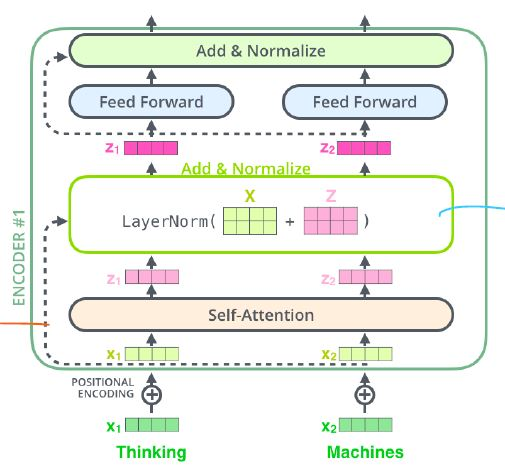

4.  single encoder consists of self attention layers, add normalize, feed forwoard and skip connection, number of layers depend on model type small have 12 layers and large have 24 layers.

5. Single attention head:

  1. it has query (q_i), keys (k_i) and values(v_i) vectors.
  2. multiply q_i to k_i. 
  3. divide by generally (8)/ (srt(d), where d is found by expermentally 8 fits best).
  4. then pass through softmax, this softmax is multiplied by v_i to get z_i, larger the pdt of softmax and v_i, more important the z_i is.  
  5. combine/concatenate multiple heads to get final Z matrix which multiply by output weights to give final output layer over this training happens.

  6. how q_i is formed, multiply embedding of text sequence (x_i) with weights (w_q/k/v) initialized.
   
   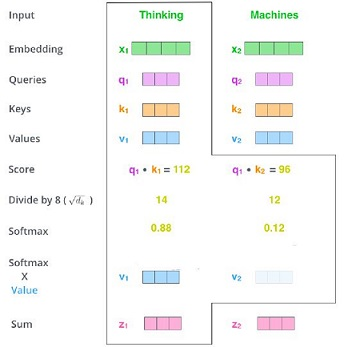

   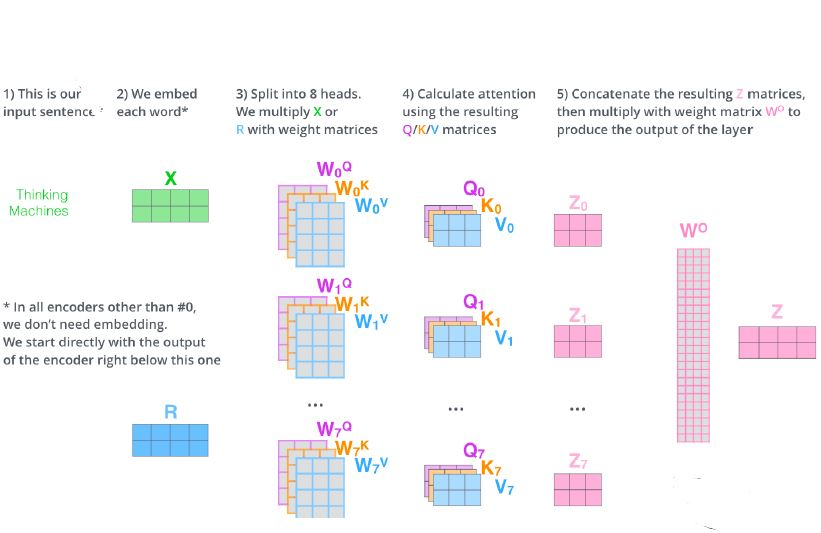

pre-processed as follows — 80% are replaced with a “[MASK]” token, 10% with a random word, and 10% use the original word.


6. Bert in this uses masked language model, in which we mask(token) some of the words in sentences in addition to this we have two more tokens namely [CLS] which contains contextual meaning of given sentence (according to implementaion) and [SEP] which signifies, seperation between two sentences/sequences.

7. After final layer (which generally has 768/512 vectors for each word) it passes through softmax for classification.

8. Bert layer details :
used bert based uncased 12-layer, 768-hidden, 12-heads, 110M parameters.
Trained on lower-cased English text.

###WORKING

**LOGISTIC REGRESSION**

In [ ]:
from tqdm import tqdm
params = [{'classifier': [LogisticRegression(random_state=42)],
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1.25, 1.5, 1.75, 2.0],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        "classifier__penalty": ['l2'],
        "classifier__solver": ['liblinear']}]      #["newton-cg", "liblinear", "sag"]}]

lr_pred_bert, best_clf = model(x_train_bert, y_train, x_test_bert, tqdm(params), 'logistic_regression')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_log_reg_bert.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 433.21it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 16.0min finished


best cv params for logistic_regression model : {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier__C': 0.5, 'classifier': LogisticRegression(C=0.5, class_weight={0: 3.82, 1: 1.0}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)}
best cv score for logistic_regression model  : 0.6168774085561138


In [ ]:
metrics(y_test, lr_pred_bert)

Hamming Loss      :  0.19902120717781402
Exact Match Ratio :  0.5579119086460033
Recall            :  0.5587340231284236
Precision         :  0.7110766847405112
Fl score          :  0.6257668711656442


In [ ]:
##LABEL POWESET HAVE NO CV_RESULT_ PARAM SO CANNOT PLOT FOR CV SCORES.

**SVM**

In [ ]:
%%time
from tqdm import tqdm
from sklearn.svm import LinearSVC
params = [{'classifier': [SVC(random_state=42)],         #linearsvc consider
        "classifier__C": [ 0.0001, 0.001, 0.1, 0.75, 1.0,  1.5, 2.0, 10],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}],
        'classifier__kernel':['poly', 'rbf']}]

cvm_lin_pred_bert, best_clf = model(x_train_bert, y_train, x_test_bert, tqdm(params), 'svc lin')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_lin_svc_bert.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 466.03it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 52.4min finished


best cv params for svc lin model : {'classifier__kernel': 'poly', 'classifier__class_weight': {0: 3.82, 1: 1.0}, 'classifier__C': 10, 'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight={0: 3.82, 1: 1.0},
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='poly', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)}
best cv score for svc lin model  : 0.6203651969636895
CPU times: user 56min 10s, sys: 2.8 s, total: 56min 13s
Wall time: 56min 2s


In [ ]:
metrics(y_test, cvm_lin_pred_bert)

Hamming Loss      :  0.20174007612833061
Exact Match Ratio :  0.5486677542142468
Recall            :  0.5429093122337189
Precision         :  0.7113237639553429
Fl score          :  0.6158094580600622


**DT**

In [ ]:
 %%time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
params = [{'classifier'                      : [DecisionTreeClassifier()],
          'classifier__criterion'            : ['gini', 'entropy'], 
          'classifier__max_depth'            : [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], 
          'classifier__min_samples_split'    : [2, 3, 4, 5, 6, 7, 8, 10]}]

dt_pred_bert, best_clf = model(x_train_bert, y_train, x_test_bert, tqdm(params), 'decision tree')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_dt_bert.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 484.11it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  9.0min finished


best cv params for decision tree model : {'classifier__min_samples_split': 2, 'classifier__max_depth': 18, 'classifier__criterion': 'entropy', 'classifier': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=18, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')}
best cv score for decision tree model  : 0.41656275306710205
CPU times: user 10min 53s, sys: 486 ms, total: 10min 54s
Wall time: 10min 52s


In [ ]:
metrics( y_test, dt_pred_bert)

Hamming Loss      :  0.347652709806054
Exact Match Ratio :  0.30886351277868407
Recall            :  0.4175289105295192
Precision         :  0.416514875531269
Fl score          :  0.41702127659574467


**RANDOM FOREST**

In [ ]:
%%time
from tqdm import tqdm
params = [{'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 80, 250, 500],
        'classifier__max_depth'   : [5,8,10, 20, 50, 100, 250],
        'classifier__max_features' : ['sqrt', 'log2'],
        'classifier__max_samples' : [0.6, 0.75, 1],
        "classifier__class_weight" : [{0:1.61 ,1:1.0}, {0:3.82 ,1:1.0}, {0:2.3, 1:1.0}]}]

rf_pred_bert, best_clf = model(x_train_bert, y_train, x_test_bert, tqdm(params), 'random forest')
pickle.dump((best_clf), open('/content/gdrive/MyDrive/cs1/best_clf_rf_bert.pkl','wb'))

100%|██████████| 1/1 [00:00<00:00, 164.12it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.3min finished


best cv params for random forest model : {'classifier__n_estimators': 250, 'classifier__max_samples': 0.6, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 50, 'classifier__class_weight': {0: 1.61, 1: 1.0}, 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.61, 1: 1.0}, criterion='gini',
                       max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=0.6, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)}
best cv score for random forest model  : 0.4691359856489772
CPU times: user 6min 59s, sys: 990 ms, total: 7min
Wall time: 6min 59s


In [ ]:
metrics(y_test, rf_pred_bert)

Hamming Loss      :  0.2374478883451151
Exact Match Ratio :  0.4866775421424687
Recall            :  0.34692635423006696
Precision         :  0.7063197026022305
Fl score          :  0.4653061224489796


In [ ]:
from prettytable import PrettyTable
k5 = PrettyTable()
k5.field_names = ["Vectorizer","Model","Hamming loss","EMR","Recall","Precision","F1 score",]
k5.add_row(["bert + Numerical",'LOGISTIC REGRESSION',0.1990, 0.5579, 0.5587, 0.7111, 0.6258])
k5.add_row(["bert + Numerical",'LINEAR SVM',0.2017, 0.4279, 0.4437, 0.7113, 0.6158])
k5.add_row(["bert + Numerical",'DESICION TREE',0.3477, 0.5487, 0.5429, 0.41651, 0.4170])
k5.add_row(["bert + Numerical",'RANDOM FOREST',0.2374, 0.4867, 0.3469, 0.70632, 0.4653])
print(k5)

+------------------+---------------------+--------------+--------+--------+-----------+----------+
|    Vectorizer    |        Model        | Hamming loss |  EMR   | Recall | Precision | F1 score |
+------------------+---------------------+--------------+--------+--------+-----------+----------+
| bert + Numerical | LOGISTIC REGRESSION |    0.199     | 0.5579 | 0.5587 |   0.7111  |  0.6258  |
| bert + Numerical |      LINEAR SVM     |    0.2017    | 0.4279 | 0.4437 |   0.7113  |  0.6158  |
| bert + Numerical |    DESICION TREE    |    0.3477    | 0.5487 | 0.5429 |  0.41651  |  0.417   |
| bert + Numerical |    RANDOM FOREST    |    0.2374    | 0.4867 | 0.3469 |  0.70632  |  0.4653  |
+------------------+---------------------+--------------+--------+--------+-----------+----------+
